# Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ for DESIJ1554+0443

**Author(s)**: Zareef Jafar, Muhammad Jobair Hasan, Sulyman Hossain, Anowar Shajib <br>
**Acknowledgement(s)**: Ahmad Al - Imtiaz, Mamunur Rashid


## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Load Data

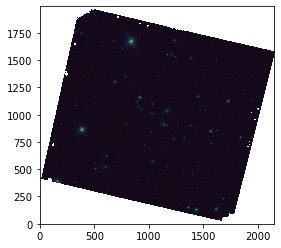

In [2]:
data, header = fits.getdata("DESIJ1554+0443_F140W_drz_sci.fits", header=True)
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

/tmp/ipykernel_36640/3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


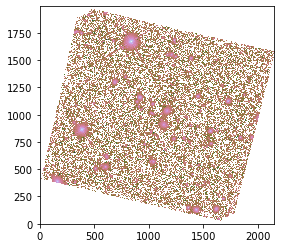

In [3]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry and Plotting

In [4]:
# Background subtraction
bkg_subtracted_data = data - bkg.background
# Source detection and segmentation
threshold = 3 * bkg.background_rms
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)
# Source catalog creation
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print("SEGMENT MAP:\n", segment_map, "\n\nCAT:\n", cat)

SEGMENT MAP:
 <photutils.segmentation.core.SegmentationImage>
shape: (1994, 2152)
nlabels: 862
labels: [  1   2   3   4   5 ... 858 859 860 861 862] 

CAT:
 <photutils.segmentation.catalog.SourceCatalog>
Length: 862
labels: [  1   2   3   4   5 ... 858 859 860 861 862]


## Adjust the region surrounding your lensing system

In [5]:
# Set axis limits
set_x_lim1, set_x_lim2 = 997 - 150, 997 + 500
set_y_lim1, set_y_lim2 = 1076 - 310, 1076 + 250

/tmp/ipykernel_36640/3069424679.py:6: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


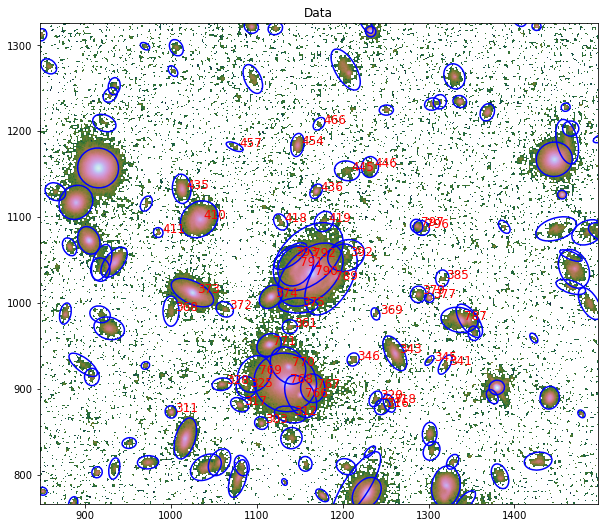

In [6]:
# Plotting
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
# Before determining the central ID
# for i in range(len(cat)):
#     ax1.text(
#         cat.xcentroid[i] + 5,
#         cat.ycentroid[i],
#         f"{i}",
#         c="r",
#         fontsize=12
#     )

# After determining the central ID
id_central = 790
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[id_central]) < 180
        and np.abs(cat.ycentroid[i] - cat.ycentroid[id_central]) < 180
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)


ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [7]:
# Defining a function for labeling only selected objects


def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))

    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
        if (
            np.abs(cat.xcentroid[obj_id] - cat.xcentroid[id_central]) < 180
            and np.abs(cat.ycentroid[obj_id] - cat.ycentroid[id_central]) < 180
        ):
            ax1.text(
                cat.xcentroid[obj_id] + 5,
                cat.ycentroid[obj_id],
                f"{obj_id}",
                c="r",
                fontsize=12
                # transform=ax1.transAxes
            )

    # Set axis limits
    ax1.set_xlim(set_x_lim1, set_x_lim2)
    ax1.set_ylim(set_y_lim1, set_y_lim2)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()

## The central deflector

/tmp/ipykernel_36640/1139147308.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


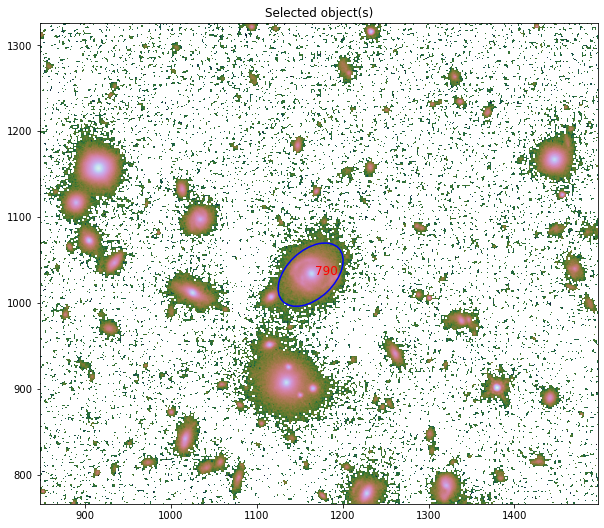

In [8]:
# object id of your central deflector/lens
id_central = 790

label_selected_objects([id_central])

In [9]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating Lists of neighbouring Galaxies

Number of All Close galaxies within 30 arcseconds radius: 154


/tmp/ipykernel_36640/1139147308.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


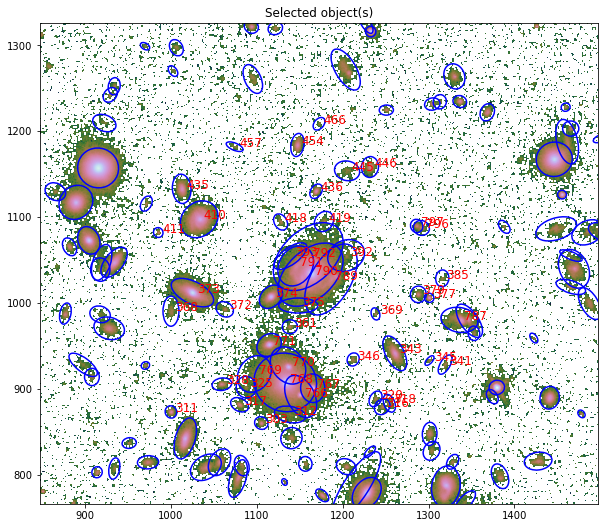

In [10]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08:  # radius: 30 arcseconds
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of All Close galaxies within 30 arcseconds radius:", len(close_galaxies_all)
)
label_selected_objects(close_galaxies_all)

Number of Close galaxies (excluding the dim sources) within 30 arcseconds radius:  72


/tmp/ipykernel_36640/1139147308.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


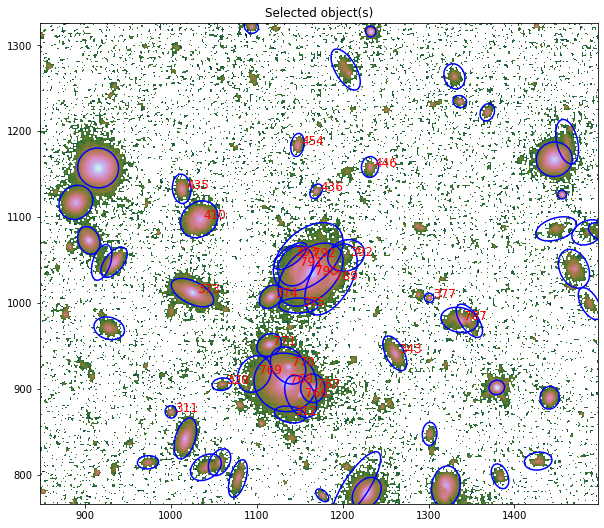

In [11]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08) & (
        f > f0 * 0.01
    ):  # radius: 30 arcseconds
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of Close galaxies (excluding the dim sources) within 30 arcseconds radius: ",
    len(close_galaxies_1),
)
label_selected_objects(close_galaxies_1)

In [12]:
def distance_parsec(pixel_distance):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180
    
    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian
    
    # Define cosmological parameters
    H0 = 70   # Hubble constant in km/s/Mpc
    Om0 = 0.3 # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # Define the redshifts at which you want to compute the angular diameter distance
    z = 0.591
    
    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)
    
    # Calculate the physical distance  ## Change
    physical_distances_parsecs = angular_diameter_distance * angles_radian
    return physical_distances_parsecs

## Identify the unwanted objects

/tmp/ipykernel_36640/1139147308.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


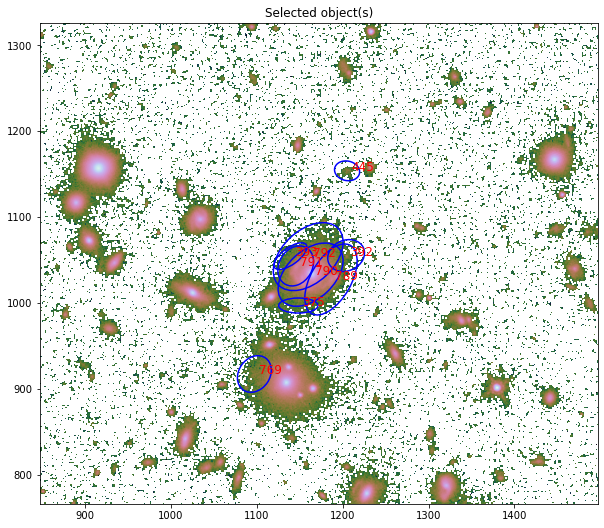

In [13]:
# For the list including all galaxies

# Lensed Arcs: 789, 791, 792
# Artifacts: 393, 375, 392, 769, 445
# Central deflector: 790
id_central_1drop = [
    393,
    792,  
    791, 
    789, 
    375,
    790,
    769,
    445,
    392, 
]
label_selected_objects(id_central_1drop)

/tmp/ipykernel_36640/1139147308.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


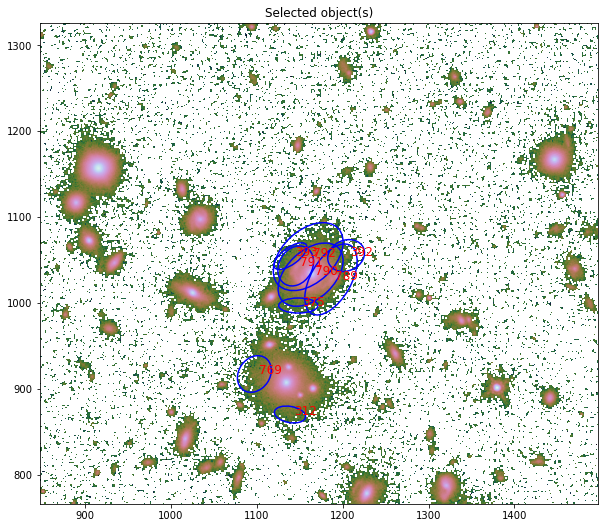

In [14]:
# For the list excluding dim sources

# Lensed Arcs: 789, 791, 792
# Artifacts: 393, 375, 392, 769, 312
# Central deflector: 790
id_central_2drop = [
    393,
    792,  
    791, 
    789, 
    375,
    790,
    769,
    312,
    392, 
]
label_selected_objects(id_central_2drop)

### 20 Neighbouring Galaxies excluding central deflector, lensed arc , stars and other

In [15]:
df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# drop the central and other unwanted ids
df_all = df_all.drop(index=id_central_1drop)

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")
df_all_sys_removed = df_all_sorted

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(megaparsec)         Flux  Axis Ratio
374         52.929404              0.028110   106.767505    0.731401
419         63.867673              0.033919     6.434641    0.825256
361         65.365138              0.034714     5.138200    0.920563
418         70.594477              0.037491     4.021506    0.720744
369         88.339872              0.046916     2.059620    0.673577
771         95.040682              0.050474   108.461691    0.799265
436         97.362424              0.051707    15.236387    0.688385
372        107.814307              0.057258     5.362714    0.804520
770        109.024855              0.057901   139.946412    0.770816
346        110.538518              0.058705     3.511109    0.850340
379        127.575819              0.067753     8.771198    0.949866
768        128.908353              0.068461  1049.058422    0.924462
767        132.361832              0.070295   133.264701    0.845918
343        134.234566             

### 20 Neighbouring Galaxies excluding central deflector, lensed arc , stars and other + dim sources

In [16]:
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1


# Exclude the lensing system and other undesirable members
df_1_sys_removed = df_1.drop(index=id_central_2drop)

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1_sys_removed.sort_values(by="Distance(pixels)")

# first 20 galaxies
df_1_20 = df_1_sorted.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(megaparsec)         Flux  Axis Ratio
374         52.929404              0.028110   106.767505    0.731401
771         95.040682              0.050474   108.461691    0.799265
436         97.362424              0.051707    15.236387    0.688385
770        109.024855              0.057901   139.946412    0.770816
768        128.908353              0.068461  1049.058422    0.924462
767        132.361832              0.070295   133.264701    0.845918
343        134.234566              0.071289    64.541193    0.482311
373        139.213753              0.073934   415.886073    0.487092
377        140.622685              0.074682    11.876507    0.920711
766        142.398345              0.075625    77.675807    0.614627
446        143.189982              0.076045    17.732344    0.812085
410        144.952402              0.076981   271.032770    0.834178
454        151.828211              0.080633    26.439004    0.555517
328        164.224164             

## Determining $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ and the corresponding radii

/tmp/ipykernel_36640/4092589062.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_36640/4092589062.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_36640/4092589062.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_36640/4092589062.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


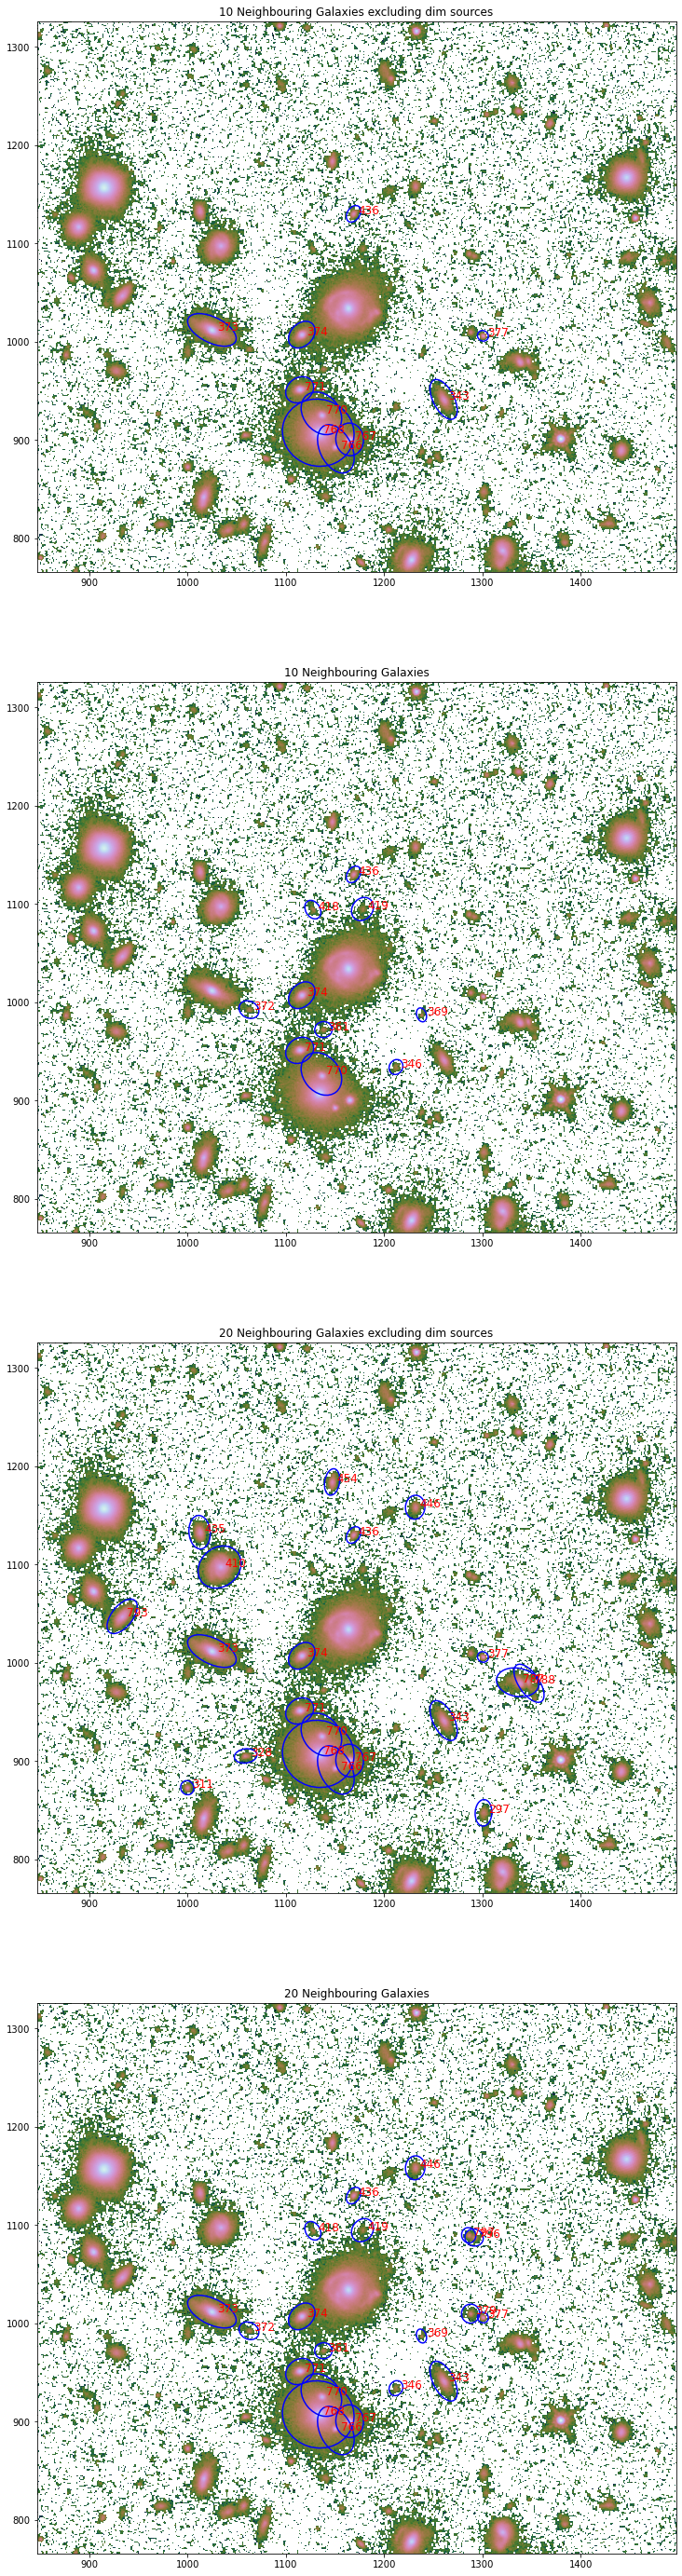

In [17]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(4, 1, figsize=(25, 50))  # , figsize=(10, 12.5)

axs[0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[2].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[3].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[2], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[3], color="blue", lw=1.5)

axs[0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[1].set_title("10 Neighbouring Galaxies")
axs[2].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[3].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[2].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[3].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0].set_xlim(set_x_lim1, set_x_lim2)
axs[0].set_ylim(set_y_lim1, set_y_lim2)

axs[1].set_xlim(set_x_lim1, set_x_lim2)
axs[1].set_ylim(set_y_lim1, set_y_lim2)

axs[2].set_xlim(set_x_lim1, set_x_lim2)
axs[2].set_ylim(set_y_lim1, set_y_lim2)

axs[3].set_xlim(set_x_lim1, set_x_lim2)
axs[3].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0].set_clip_on(True)
axs[0].set_clip_box(axs[0].bbox)

axs[1].set_clip_on(True)
axs[1].set_clip_box(axs[0].bbox)

axs[2].set_clip_on(True)
axs[2].set_clip_box(axs[0].bbox)

axs[3].set_clip_on(True)
axs[3].set_clip_box(axs[0].bbox)

## Calculating $\Sigma_{10}$, $\Sigma_{10,\text{flux selected}}$ , $\Sigma_{20}$, $\Sigma_{20,\text{flux selected}}$ and the corresponding radii

## Method A

In [18]:
# For all sources
R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_allA = 10 / (np.pi * R_10_all**2)
Sigma_20_allA = 20 / (np.pi * R_20_all**2)

# Excluding dim sources
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_1A = 10 / (np.pi * R_10_1**2)
Sigma_20_1A = 20 / (np.pi * R_20_1**2)


print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA)
print("Sigma 20:", Sigma_20_allA)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A)
print("Sigma 20:", Sigma_20_1A)


FOR All SOURCES
R 10: 0.05870488879085888
R 20: 0.07604545615714739
Sigma 10: 923.6375656198019
Sigma 20: 1100.8637831301494

EXCLUDING DIM SOURCES
R 10: 0.07562503269602647
R 20: 0.12300133816679487
Sigma 10: 556.5689529537208
Sigma 20: 420.7851943321905


## Method B

In [19]:
weighted_flux_10_all = np.sum(df_all_20["Flux"][0:10] / np.max(df_all_20["Flux"][0:10]))
weighted_flux_20_all = np.sum(df_all_20["Flux"][0:20] / np.max(df_all_20["Flux"][0:20]))
Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all**2)


weighted_flux_10_1 = np.sum(df_1_20["Flux"][0:10] / np.max(df_1_20["Flux"][0:10]))
weighted_flux_20_1 = np.sum(df_1_20["Flux"][0:20] / np.max(df_1_20["Flux"][0:20]))
Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB)
print("Sigma 20_updated:", Sigma_20_allB)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B)
print("Sigma 20_updated:", Sigma_20_1B)


Considering Light Flux
FOR All SOURCES
R 10: 0.05870488879085888
R 20: 0.07604545615714739
Sigma 10_updated: 261.97777384018474
Sigma 20_updated: 114.8695120601676

EXCLUDING DIM SOURCES
R 10: 0.07562503269602647
R 20: 0.12300133816679487
Sigma 10_updated: 112.61880863509083
Sigma 20_updated: 54.61636010150211


## Method C

In [20]:
flux_10_all = []
flux_20_all = []
flux_10_1 = []
flux_20_1 = []

# for all sources
for i in range(20):
    flux_all = df_all_20["Flux"][i:i+1] / df_all_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_10_all.append(flux_all)
        flux_20_all.append(flux_all)
        
    elif 9 < i < 20:
        flux_20_all.append(flux_all)
        
weighted_flux_10_all = np.sum(flux_10_all / np.max(flux_10_all))
weighted_flux_20_all = np.sum(flux_20_all / np.max(flux_20_all))
Sigma_10_allC = weighted_flux_10_all  / (np.pi * R_10_all**2)
Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all**2)

# excluding dim sources
for i in range(20):
    flux_1 = df_1_20["Flux"][i:i+1] / df_1_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_10_1.append(flux_1)
        flux_20_1.append(flux_1)
        
    elif 9 < i < 20:
        flux_20_1.append(flux_1)
        
weighted_flux_10_1 = np.sum(flux_10_1 / np.max(flux_10_1))
weighted_flux_20_1 = np.sum(flux_20_1 / np.max(flux_20_1))
Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC)
print("Sigma 20_updated:", Sigma_20_allC)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C)
print("Sigma 20_updated:", Sigma_20_1C)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.05870488879085888
R 20: 0.07604545615714739
Sigma 10_updated: 226.18005302441412
Sigma 20_updated: 124.94756755749489

EXCLUDING DIM SOURCES
R 10: 0.07562503269602647
R 20: 0.12300133816679487
Sigma 10_updated: 122.02000040352466
Sigma 20_updated: 55.390022237240586


## Method D

In [21]:
# Initialize flux variables
flux_10_all = []
flux_20_all = []
flux_10_1 = []
flux_20_1 = []

# Define a short radius
pixel_distance = 125 # for 10 arcseconds
s = distance_parsec(pixel_distance).value

# Process both dataframes
for i in range(20):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]
    
    # Processing for df_all_20
    if i < 10:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_10_all.append(flux_contrib_all)
        flux_20_all.append(flux_contrib_all)
        
    elif 9 < i < 20:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_20_all.append(flux_contrib_all)
    
    # Processing for df_1_20
    if i < 10:
        
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_10_1.append(flux_contrib_1)
        flux_20_1.append(flux_contrib_1)
        
    elif 9 < i < 20:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_20_1.append(flux_contrib_1)

weighted_flux_10_all = np.sum(flux_10_all / np.max(flux_10_all))
weighted_flux_20_all = np.sum(flux_20_all / np.max(flux_20_all))
Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all**2)

weighted_flux_10_1 = np.sum(flux_10_1 / np.max(flux_10_1))
weighted_flux_20_1 = np.sum(flux_20_1 / np.max(flux_20_1))
Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1**2)

# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD)
print("Sigma 20_updated:", Sigma_20_allD)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D)
print("Sigma 20_updated:", Sigma_20_1D)



Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.05870488879085888
R 20: 0.07604545615714739
Sigma 10_updated: 261.97777384018474
Sigma 20_updated: 113.01559780356888

EXCLUDING DIM SOURCES
R 10: 0.07562503269602647
R 20: 0.12300133816679487
Sigma 10_updated: 110.83669350083792
Sigma 20_updated: 51.16254067960971


## Store the $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ values in the YAML file

In [22]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1554+0443_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": Sigma_10_1A,
    "Sigma_20a_flux_selected": Sigma_20_1A,
    "Sigma_10a": Sigma_10_allA,
    "Sigma_20a": Sigma_20_allA,
    
    "Sigma_10b_flux_selected": Sigma_10_1B,
    "Sigma_20b_flux_selected": Sigma_20_1B,
    "Sigma_10b": Sigma_10_allB,
    "Sigma_20b": Sigma_20_allB,
    
    "Sigma_10c_flux_selected": Sigma_10_1C,
    "Sigma_20c_flux_selected": Sigma_20_1C,
    "Sigma_10c": Sigma_10_allC,
    "Sigma_20c": Sigma_20_allC,
    
    "Sigma_10d_flux_selected": Sigma_10_1D,
    "Sigma_20d_flux_selected": Sigma_20_1D,
    "Sigma_10d": Sigma_10_allD,
    "Sigma_20d": Sigma_20_allD
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [23]:
# Read the YAML file using safe_load

with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 37
{'R_eff_light': 0.7774285505755497, 'Sigma_10': 0.000923637565619802, 'Sigma_10_flux_selected': 0.0005565689529537207, 'Sigma_10a': 923.6375656198019, 'Sigma_10a_flux_selected': 556.5689529537208, 'Sigma_10b': 261.97777384018474, 'Sigma_10b_flux_selected': 112.61880863509083, 'Sigma_10c': 226.18005302441412, 'Sigma_10c_flux_selected': 122.02000040352466, 'Sigma_10d': 261.97777384018474, 'Sigma_10d_flux_selected': 110.83669350083792, 'Sigma_10f_1': 0.0018697735162105994, 'Sigma_10f_all': 0.000859084256988187, 'Sigma_20': 0.0011008637831301498, 'Sigma_20_flux_selected': 0.00042078519433219055, 'Sigma_20a': 1100.8637831301494, 'Sigma_20a_flux_selected': 420.7851943321905, 'Sigma_20b': 114.8695120601676, 'Sigma_20b_flux_selected': 54.61636010150211, 'Sigma_20c': 124.94756755749489, 'Sigma_20c_flux_selected': 55.390022237240586, 'Sigma_20d': 113.01559780356888, 'Sigma_20d_flux_selected': 51.16254067960971, 'Sigma_20f_1': 0.0008487690239223851, 'Sigma_20f_all'